## IMPORT LIBRARIES

In [8]:
import os
import warnings
from scipy import ndimage

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    f1_score, 
    cohen_kappa_score,
    classification_report, 
    confusion_matrix
)

warnings.filterwarnings('ignore')

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## LOADING AND PREPROCESSING MRI DATASET  

In [ ]:
def find_brain_contour(img):
    # Apply threshold to create binary image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour (should be the brain)
        largest_contour = max(contours, key=cv2.contourArea)
        return largest_contour
    return None

def crop_brain_region(img):
    # Find brain contour
    contour = find_brain_contour(img)
    
    if contour is not None:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add padding
        padding = 10
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(img.shape[1] - x, w + 2 * padding)
        h = min(img.shape[0] - y, h + 2 * padding)
        
        # Crop the image
        cropped = img[y:y+h, x:x+w]
        
        # Create mask for brain region
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], 255)
        cropped_mask = mask[y:y+h, x:x+w]
        
        # Apply mask to remove background
        cropped[cropped_mask == 0] = 0
        
        return cropped
    
    return img

def standardize_brain_image(img):
    # Remove very dark pixels (background)
    brain_pixels = img[img > 10]
    
    if len(brain_pixels) > 0:
        # Calculate statistics only from brain tissue
        mean_intensity = np.mean(brain_pixels)
        std_intensity = np.std(brain_pixels)
        
        # Clip outliers (3-sigma rule for medical images)
        lower_bound = mean_intensity - 3 * std_intensity
        upper_bound = mean_intensity + 3 * std_intensity
        img = np.clip(img, lower_bound, upper_bound)
        
        # Z-score normalization for medical images
        img = (img - mean_intensity) / (std_intensity + 1e-8)  # Add epsilon to avoid division by zero
        
        # Scale to [0, 1] range
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = np.zeros_like(img)
    
    return img.astype(np.float32)

def preprocess_image(img_path):
    # Read image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    
    # Crop brain region and remove background
    img = crop_brain_region(img)
    
    # Denoise using Non-local Means Denoising
    img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    
    # Standardize intensity (medical imaging approach)
    img = standardize_brain_image(img)
    
    # Convert back to uint8 for CLAHE
    img_uint8 = (img * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_uint8 = clahe.apply(img_uint8)
    img = img_uint8.astype(np.float32) / 255.0
    
    # Morphological operations to clean up
    kernel = np.ones((3,3), np.uint8)
    img_uint8 = (img * 255).astype(np.uint8)
    img_uint8 = cv2.morphologyEx(img_uint8, cv2.MORPH_CLOSE, kernel)
    img = img_uint8.astype(np.float32) / 255.0
    
    # Resize to standard size (224x224)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
    
    # Keep as single channel for custom model
    # Add channel dimension: [H, W] -> [1, H, W]
    img = img[np.newaxis, :, :]
    
    # Final normalization for neural network
    # Standardize to mean=0, std=1 (common for medical images)
    img = (img - 0.5) / 0.5  # Maps [0,1] to [-1,1]
    
    return torch.tensor(img, dtype=torch.float32)

In [16]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collect all samples
        self.samples = []
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            if os.path.isdir(cls_folder):
                for fname in os.listdir(cls_folder):
                    if fname.lower().endswith(('.jpg', '.jpeg')):
                        self.samples.append((os.path.join(cls_folder, fname), self.class_to_idx[cls]))
        
        print(f"{len(self.samples)} images across {len(self.classes)} classes")
        for cls, idx in self.class_to_idx.items():
            count = sum(1 for _, label in self.samples if label == idx)
            print(f"  {cls}: {count} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = preprocess_image(img_path)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # CHANGED: Return a dummy tensor in case of error (single channel)
            return torch.zeros(1, 224, 224, dtype=torch.float32), label


def test_preprocessing(dataset, num_samples=None):
    print("Sampling one example from each class and preprocessing...")
    
    # Get one sample per class
    samples_per_class = {}
    for img_path, label in dataset.samples:
        if label not in samples_per_class:
            samples_per_class[label] = img_path
            
    # Sort by class label for consistent ordering
    sorted_samples = sorted(samples_per_class.items())
    num_classes = len(sorted_samples)
    
    fig, axes = plt.subplots(3, num_classes, figsize=(5 * num_classes, 12))
    
    # Handle case where there's only one class
    if num_classes == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (label, img_path) in enumerate(sorted_samples):
        class_name = dataset.classes[label]
        
        # Original image
        original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[0, i].imshow(original, cmap='gray')
        axes[0, i].set_title(f'Original: {class_name}')
        axes[0, i].axis('off')
        
        # Cropped brain region
        cropped = crop_brain_region(original)
        axes[1, i].imshow(cropped, cmap='gray')
        axes[1, i].set_title(f'Cropped Brain: {class_name}')
        axes[1, i].axis('off')
        
        # Final preprocessed image
        processed_tensor = preprocess_image(img_path)
        processed = processed_tensor[0].numpy()  # Take the single channel
        # Denormalize for display: from [-1,1] to [0,1]
        processed = (processed + 1) / 2
        processed = np.clip(processed, 0, 1)
        
        axes[2, i].imshow(processed, cmap='gray')
        axes[2, i].set_title(f'Final Processed: {class_name}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    

Loading datasets...
Training dataset: 5712 images across 4 classes
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images
Testing dataset: 1311 images across 4 classes
  glioma: 300 images
  meningioma: 306 images
  notumor: 405 images
  pituitary: 300 images
Sampling one example from each class and preprocessing...


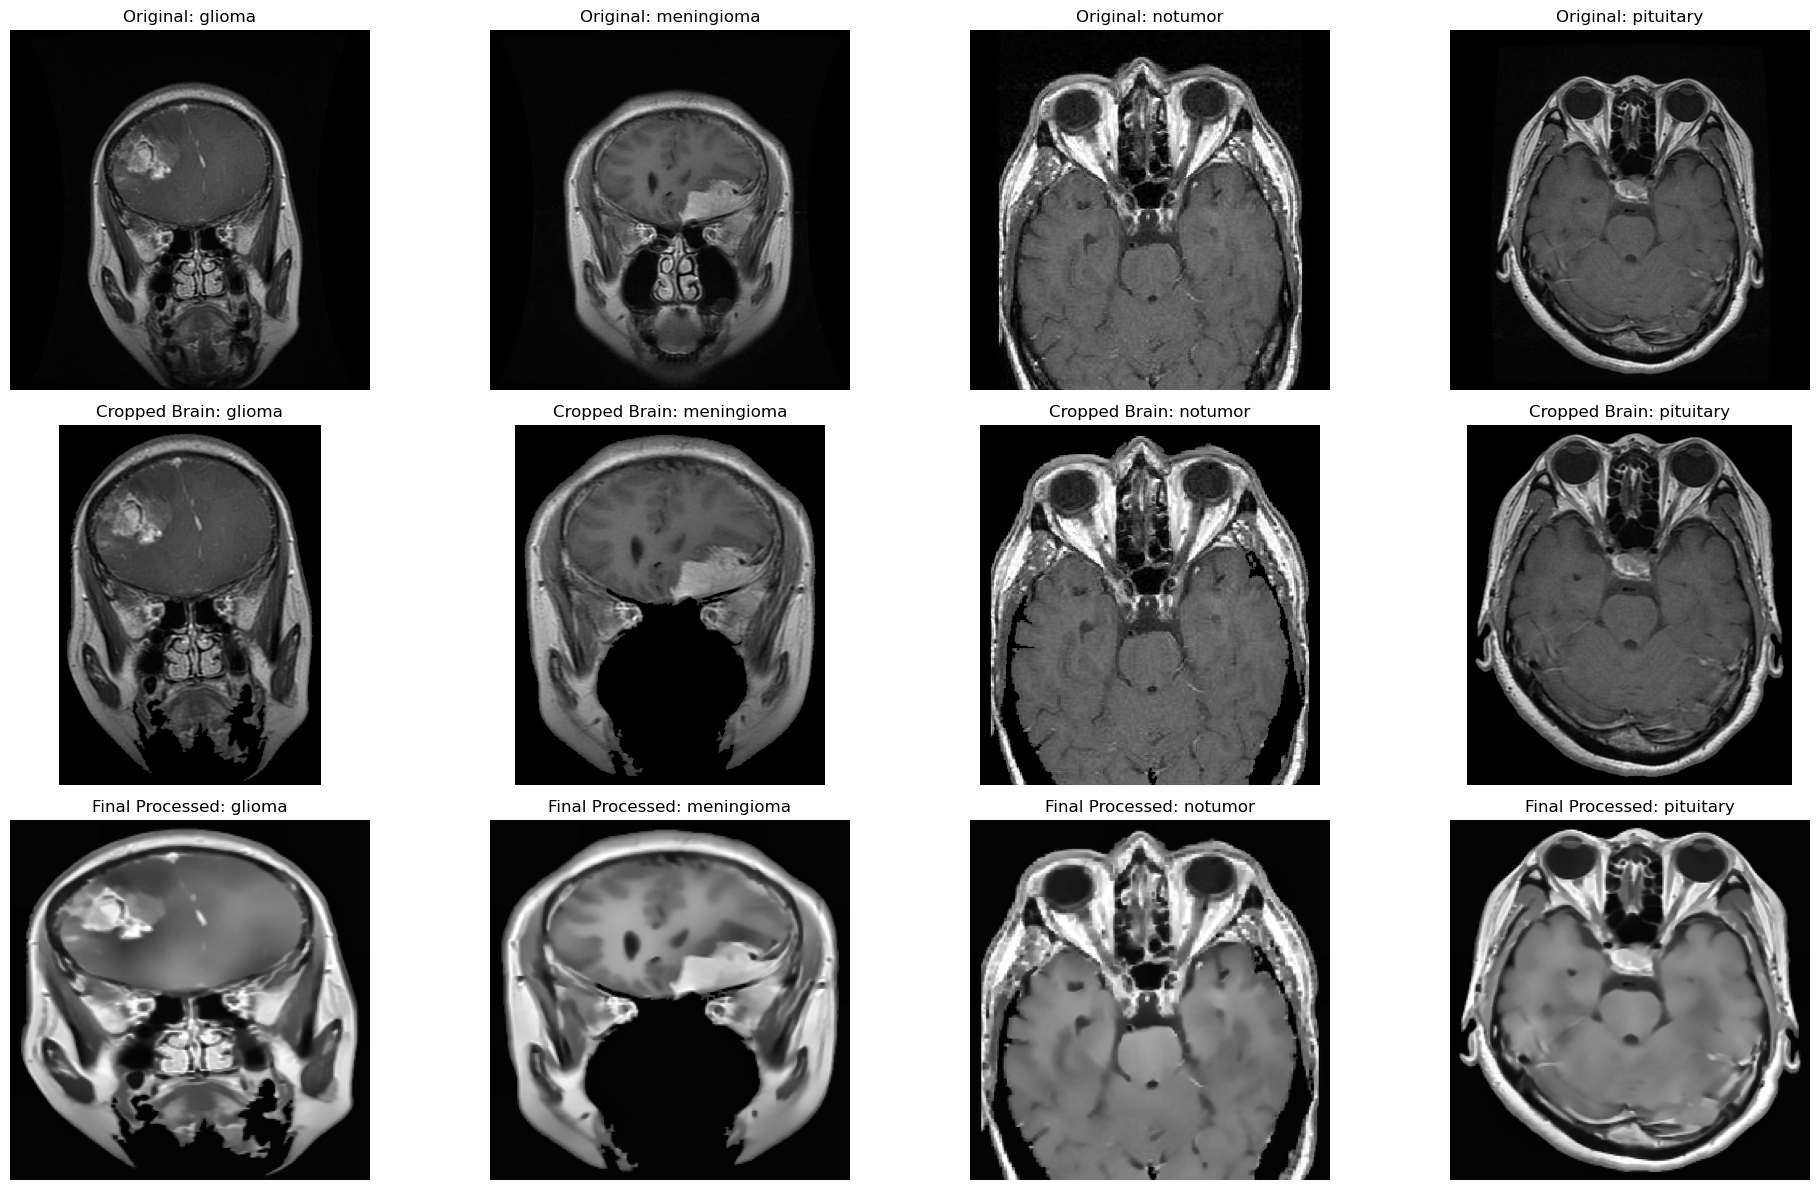

Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [25]:

# Dataset paths
DATASET_PATH_TRAINING = "MRI DATASET/training" 
DATASET_PATH_TESTING = "MRI DATASET/testing"

print("Loading datasets...")

# Load training dataset
print("Training dataset:", end=" ")
train_dataset = BrainTumorDataset(DATASET_PATH_TRAINING)

# Load testing dataset
print("Testing dataset:", end=" ")
test_dataset = BrainTumorDataset(DATASET_PATH_TESTING)


# Test preprocessing on training data
test_preprocessing(train_dataset, num_samples=4)

# Get number of classes from training dataset
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

In [26]:
print("DATASET SPLIT")

# We have separate test set, so split training into train/val only
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size


print(f"Split training set:")
print(f"  Train: {train_size} images (80%)")
print(f"  Validation: {val_size} images (20%)")
print(f"Test set: {len(test_dataset)} images")


DATASET SPLIT
Split training set:
  Train: 4569 images (80%)
  Validation: 1143 images (20%)
Test set: 1311 images


In [27]:

# Split training dataset into train/validation
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

# Use the separate test dataset for final testing
test_ds = test_dataset
    
print("CREATE DATA LOADERS")

# Batch sizes
batch_size_train = 4  # Can be larger for single channel
batch_size_eval = 2*batch_size_train   # Larger batch for evaluation (no dropout, faster)

# Training loader
train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size_train, 
    shuffle=True,           # Shuffle for training
    pin_memory=True,
    num_workers=0,          # Parallel data loading
    drop_last=True          # Drop incomplete batch for consistent batch norm
)

# Validation loader
val_loader = DataLoader(
    val_ds, 
    batch_size=batch_size_eval, 
    shuffle=False,          # No shuffling for validation
    pin_memory=True,
    num_workers=0
)

# Test loader
test_loader = DataLoader(
    test_ds, 
    batch_size=batch_size_eval, 
    shuffle=False,          # No shuffling for testing
    pin_memory=True,
    num_workers=0
)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)} (batch size: {batch_size_train})")
print(f"  Validation batches: {len(val_loader)} (batch size: {batch_size_eval})")
print(f"  Test batches: {len(test_loader)} (batch size: {batch_size_eval})")

CREATE DATA LOADERS
Data loaders created:
  Train batches: 1142 (batch size: 4)
  Validation batches: 143 (batch size: 8)
  Test batches: 164 (batch size: 8)


In [28]:
def print_dataset_stats(dataset, name):
    """Print statistics for a dataset"""
    from collections import Counter
    
    print(f"\n{name} Dataset Statistics:")
    if hasattr(dataset, 'dataset'):  # For random_split datasets
        samples = dataset.dataset.samples
        indices = dataset.indices
        relevant_samples = [samples[i] for i in indices]
    else: 
        relevant_samples = dataset.samples
    
    class_counts = Counter()
    for _, label in relevant_samples:
        class_name = train_dataset.classes[label]  # Use train_dataset classes as reference
        class_counts[class_name] += 1
    
    total = len(relevant_samples)
    print(f"  Total samples: {total}")
    
    for class_name in sorted(class_counts.keys()):
        count = class_counts[class_name]
        print(f"  {class_name}: {count:4d}")

# Print statistics for all datasets
print_dataset_stats(train_ds, "Training")
print_dataset_stats(val_ds, "Validation") 
print_dataset_stats(test_ds, "Test")


Training Dataset Statistics:
  Total samples: 4569
  glioma: 1069
  meningioma: 1058
  notumor: 1255
  pituitary: 1187

Validation Dataset Statistics:
  Total samples: 1143
  glioma:  252
  meningioma:  281
  notumor:  340
  pituitary:  270

Test Dataset Statistics:
  Total samples: 1311
  glioma:  300
  meningioma:  306
  notumor:  405
  pituitary:  300


## CNN - Transformer Model

In [ ]:
class CNNBackbone(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        
        # Initial feature extraction - minimal but effective
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Two residual blocks - sufficient for medical images
        self.layer1 = self.resnet_layer(32, 64, stride=2)   # 64x56x56 -> 64x28x28
        self.layer2 = self.resnet_layer(64, 128, stride=2)  # 128x28x28 -> 128x14x14
        
        # Final feature refinement
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(7)  # Force 7x7 output for consistency
        )
        
        
        
    def resnet_layer(self, in_planes, planes, stride):
        return ResBlock(in_planes, planes, stride)
    
    def forward(self, x):
        x = self.stem(x)           # [B, 32, 56, 56]
        x = self.layer1(x)         # [B, 64, 28, 28]  
        x = self.layer2(x)         # [B, 128, 14, 14]
        x = self.final_conv(x)     # [B, 256, 7, 7]
        
        return x

class ResBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, 
                              padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, 
                              padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout2d(0.1)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=2, embed_dim=192):  
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.projection = nn.Conv2d(256, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.15)  
        
    def forward(self, x):
        x = self.projection(x)  # [B, 192, 3, 3]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, 9, 192]
        x = self.norm(x)
        x = self.dropout(x)
        return x

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim=192, num_heads=6, dropout=0.15):  
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=192, num_heads=6, mlp_ratio=3.0, dropout=0.15):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = AttentionBlock(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)  
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes=4, embed_dim=192, num_heads=6, num_layers=2, dropout=0.15):
        super().__init__()
        
        # CNN backbone for feature extraction
        self.cnn_backbone = CNNBackbone(in_channels=1)
        
        # Transformer for global context
        self.patch_embed = PatchEmbedding(patch_size=2, embed_dim=embed_dim)
        self.num_patches = 9
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim) * 0.02)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
        # Transformer layers
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, dropout=dropout) 
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        # CNN feature extraction
        feature_map = self.cnn_backbone(x)  # [B, 256, 7, 7]
        
        # Patch embedding
        x = self.patch_embed(feature_map)  # [B, 9, 192]
        
        # Add class token
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, 10, 192]
        x = x + self.pos_embed
        
        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.norm(x[:, 0])  # Use class token
        x = self.head(x)
        return x

## Adjusting learning rate

In [30]:
class LRScheduler:
    def __init__(self, optimizer, num_epochs=20, max_lr=3e-3):
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.max_lr = max_lr
        self.min_lr = 1e-6
        
        # Phase boundaries
        self.warmup_epochs = int(0.35 * num_epochs)  # 35% warmup
        # Remaining 65% for cosine decay
        
        self.current_epoch = 0
        
        print(f"LR Schedule for {num_epochs} epochs:")
        print(f"  • Epochs 1-{self.warmup_epochs}: Linear warmup to {max_lr}")
        print(f"  • Epochs {self.warmup_epochs+1}-{num_epochs}: Cosine decay to {self.min_lr}")
        
    def step(self):
        if self.current_epoch < self.warmup_epochs:
            # Warmup phase: linear increase from min_lr to max_lr
            progress = self.current_epoch / self.warmup_epochs
            lr = self.min_lr + (self.max_lr - self.min_lr) * progress
            phase = "WARMUP"
        else:
            # Cosine decay phase
            decay_epochs = self.current_epoch - self.warmup_epochs
            max_decay_epochs = self.num_epochs - self.warmup_epochs
            lr = self.min_lr + (self.max_lr - self.min_lr) * 0.5 * (
                1 + np.cos(np.pi * decay_epochs / max_decay_epochs)
            )
            phase = "COSINE"
        
        # Apply learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
        self.current_epoch += 1
        return lr, phase


## Metrics Calculation

In [31]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'cohen_kappa': kappa
    }

## Training and Validationg Model

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()



def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    train_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(train_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    metrics = calculate_metrics(all_labels, all_preds)
    return avg_loss, metrics

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc='Validation')
        for data, target in val_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            
            val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    metrics = calculate_metrics(all_labels, all_preds)
    return avg_loss, metrics

def train_model(train_loader, val_loader, num_classes, device, num_epochs=20):
    model = BrainTumorClassifier(
        num_classes=num_classes,
        embed_dim=192,
        num_heads=6,
        num_layers=2,
        dropout=0.15
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    model_size = total_params * 4 / (1024*1024)
    
    print(f"Model parameters: {total_params:,}")
    print(f"Model size: {model_size:.2f} MB")
    
    # Optimized training setup
    criterion = FocalLoss(alpha=1.0, gamma=2.0)
    
    optimizer = AdamW(
        model.parameters(),
        lr=1e-6, 
        weight_decay=0.01,  
        betas=(0.9, 0.999)
    )
    
    scheduler = LRScheduler(optimizer, num_epochs, max_lr=2e-3)
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [],
        'train_acc': [], 'val_acc': [],
        'learning_rate': [], 'lr_phase': []
    }
    
    best_f1 = 0
    best_model_state = None
    patience = 7
    patience_counter = 0
    
    print("="*60)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        # Update learning rate
        current_lr, lr_phase = scheduler.step()
        
        # Training and validation
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_f1'].append(train_metrics['f1_weighted'])
        history['val_f1'].append(val_metrics['f1_weighted'])
        history['train_acc'].append(train_metrics['accuracy'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['learning_rate'].append(current_lr)
        history['lr_phase'].append(lr_phase)
        
        # Print results
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_weighted']:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_weighted']:.4f}")
        print(f"LR: {current_lr:.2e} [{lr_phase}]")
        
        # Save best model
        if val_metrics['f1_weighted'] > best_f1:
            best_f1 = val_metrics['f1_weighted']
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"New best F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history



if __name__ == "__main__":
    print("Hybrid CNN+Transformer Brain Tumor Classification")
    print("="*50)
    
    # Train model
    model, history = train_model(
        train_loader, val_loader, num_classes, device, num_epochs=25
    )
        

Hybrid CNN+Transformer Brain Tumor Classification
Model parameters: 1,552,724
Model size: 5.92 MB
LR Schedule for 25 epochs:
  • Epochs 1-8: Linear warmup to 0.002
  • Epochs 9-25: Cosine decay to 1e-06

Epoch 1/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:58<00:00,  1.20it/s, loss=0.7818]


Train - Loss: 0.7773, Acc: 0.2824, F1: 0.2140
Val   - Loss: 0.7661, Acc: 0.3027, F1: 0.1542
LR: 1.00e-06 [WARMUP]
New best F1: 0.1542

Epoch 2/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.3916]


Train - Loss: 0.4805, Acc: 0.6040, F1: 0.5955
Val   - Loss: 0.3769, Acc: 0.7270, F1: 0.7139
LR: 2.51e-04 [WARMUP]
New best F1: 0.7139

Epoch 3/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.1305]


Train - Loss: 0.3861, Acc: 0.7032, F1: 0.6984
Val   - Loss: 0.3508, Acc: 0.7305, F1: 0.7243
LR: 5.01e-04 [WARMUP]
New best F1: 0.7243

Epoch 4/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:58<00:00,  1.20it/s, loss=0.0755]


Train - Loss: 0.3781, Acc: 0.7204, F1: 0.7171
Val   - Loss: 0.2994, Acc: 0.7734, F1: 0.7760
LR: 7.51e-04 [WARMUP]
New best F1: 0.7760

Epoch 5/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:59<00:00,  1.20it/s, loss=0.0655]


Train - Loss: 0.3654, Acc: 0.7316, F1: 0.7272
Val   - Loss: 0.2735, Acc: 0.7830, F1: 0.7593
LR: 1.00e-03 [WARMUP]

Epoch 6/25
----------------------------------------


Validation: 100%|██████████| 143/143 [03:28<00:00,  1.46s/it, loss=0.7156]


Train - Loss: 0.3923, Acc: 0.7242, F1: 0.7187
Val   - Loss: 0.4196, Acc: 0.6824, F1: 0.6627
LR: 1.25e-03 [WARMUP]

Epoch 7/25
----------------------------------------


Validation: 100%|██████████| 143/143 [03:25<00:00,  1.44s/it, loss=0.0646]


Train - Loss: 0.3891, Acc: 0.7296, F1: 0.7277
Val   - Loss: 0.3579, Acc: 0.7734, F1: 0.7636
LR: 1.50e-03 [WARMUP]

Epoch 8/25
----------------------------------------


Validation: 100%|██████████| 143/143 [03:25<00:00,  1.43s/it, loss=0.1129]


Train - Loss: 0.3559, Acc: 0.7493, F1: 0.7461
Val   - Loss: 0.2651, Acc: 0.7909, F1: 0.7863
LR: 1.75e-03 [WARMUP]
New best F1: 0.7863

Epoch 9/25
----------------------------------------


Validation: 100%|██████████| 143/143 [03:21<00:00,  1.41s/it, loss=0.1118]


Train - Loss: 0.4033, Acc: 0.7088, F1: 0.7045
Val   - Loss: 0.2611, Acc: 0.7892, F1: 0.7860
LR: 2.00e-03 [COSINE]

Epoch 10/25
----------------------------------------


Validation: 100%|██████████| 143/143 [03:25<00:00,  1.44s/it, loss=0.0387]


Train - Loss: 0.3701, Acc: 0.7294, F1: 0.7261
Val   - Loss: 0.2636, Acc: 0.7979, F1: 0.7904
LR: 1.98e-03 [COSINE]
New best F1: 0.7904

Epoch 11/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.1140]


Train - Loss: 0.3488, Acc: 0.7454, F1: 0.7407
Val   - Loss: 0.5084, Acc: 0.7279, F1: 0.7216
LR: 1.93e-03 [COSINE]

Epoch 12/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:58<00:00,  1.21it/s, loss=0.0315]


Train - Loss: 0.2721, Acc: 0.8043, F1: 0.8015
Val   - Loss: 0.2081, Acc: 0.8189, F1: 0.8113
LR: 1.85e-03 [COSINE]
New best F1: 0.8113

Epoch 13/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.21it/s, loss=0.0317]


Train - Loss: 0.2653, Acc: 0.8008, F1: 0.7977
Val   - Loss: 0.1900, Acc: 0.8320, F1: 0.8300
LR: 1.74e-03 [COSINE]
New best F1: 0.8300

Epoch 14/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.21it/s, loss=0.0320]


Train - Loss: 0.2172, Acc: 0.8363, F1: 0.8336
Val   - Loss: 0.1850, Acc: 0.8513, F1: 0.8505
LR: 1.60e-03 [COSINE]
New best F1: 0.8505

Epoch 15/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:58<00:00,  1.21it/s, loss=0.0158]


Train - Loss: 0.1803, Acc: 0.8647, F1: 0.8632
Val   - Loss: 0.1888, Acc: 0.8390, F1: 0.8327
LR: 1.45e-03 [COSINE]

Epoch 16/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:58<00:00,  1.21it/s, loss=0.0130]


Train - Loss: 0.1723, Acc: 0.8728, F1: 0.8716
Val   - Loss: 0.1608, Acc: 0.8836, F1: 0.8815
LR: 1.27e-03 [COSINE]
New best F1: 0.8815

Epoch 17/25
----------------------------------------


Validation: 100%|██████████| 143/143 [02:00<00:00,  1.19it/s, loss=0.0108]


Train - Loss: 0.1387, Acc: 0.8945, F1: 0.8933
Val   - Loss: 0.1409, Acc: 0.8819, F1: 0.8810
LR: 1.09e-03 [COSINE]

Epoch 18/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.0048]


Train - Loss: 0.1102, Acc: 0.9129, F1: 0.9121
Val   - Loss: 0.1584, Acc: 0.8801, F1: 0.8789
LR: 9.08e-04 [COSINE]

Epoch 19/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.0044]


Train - Loss: 0.0984, Acc: 0.9262, F1: 0.9258
Val   - Loss: 0.1762, Acc: 0.8898, F1: 0.8875
LR: 7.27e-04 [COSINE]
New best F1: 0.8875

Epoch 20/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.21it/s, loss=0.0024]


Train - Loss: 0.0744, Acc: 0.9420, F1: 0.9416
Val   - Loss: 0.1525, Acc: 0.8810, F1: 0.8770
LR: 5.55e-04 [COSINE]

Epoch 21/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.0027]


Train - Loss: 0.0642, Acc: 0.9542, F1: 0.9539
Val   - Loss: 0.1546, Acc: 0.8950, F1: 0.8930
LR: 3.98e-04 [COSINE]
New best F1: 0.8930

Epoch 22/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.0004]


Train - Loss: 0.0420, Acc: 0.9661, F1: 0.9659
Val   - Loss: 0.1642, Acc: 0.9020, F1: 0.9005
LR: 2.62e-04 [COSINE]
New best F1: 0.9005

Epoch 23/25
----------------------------------------


Validation: 100%|██████████| 143/143 [02:11<00:00,  1.09it/s, loss=0.0633]


Train - Loss: 0.0382, Acc: 0.9724, F1: 0.9723
Val   - Loss: 0.1767, Acc: 0.9064, F1: 0.9066
LR: 1.51e-04 [COSINE]
New best F1: 0.9066

Epoch 24/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.0397]


Train - Loss: 0.0287, Acc: 0.9779, F1: 0.9778
Val   - Loss: 0.1769, Acc: 0.9073, F1: 0.9074
LR: 6.85e-05 [COSINE]
New best F1: 0.9074

Epoch 25/25
----------------------------------------


Validation: 100%|██████████| 143/143 [01:57<00:00,  1.22it/s, loss=0.0227]

Train - Loss: 0.0285, Acc: 0.9794, F1: 0.9794
Val   - Loss: 0.1723, Acc: 0.9143, F1: 0.9144
LR: 1.80e-05 [COSINE]
New best F1: 0.9144


## Training Visualization and saving model

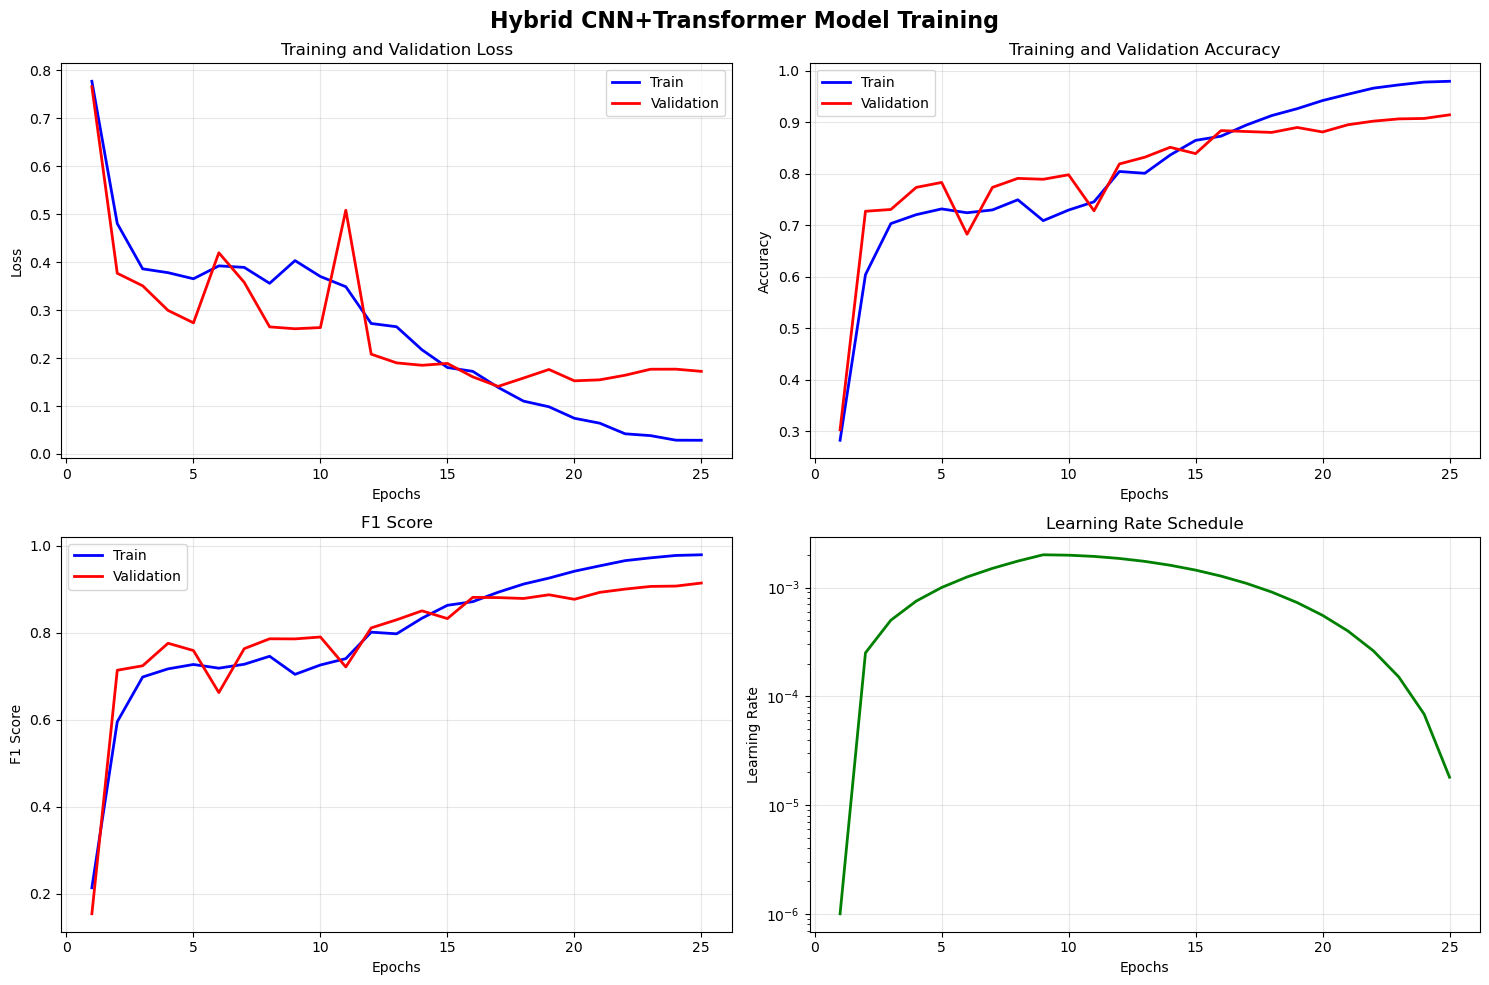

Model saved as 'hybrid_brain_tumor_model.pth'


In [37]:
def plot_training_history(history):
    """Simple but effective training visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0,0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0,0].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[0,0].set_title('Training and Validation Loss')
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0,1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    axes[0,1].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
    axes[0,1].set_title('Training and Validation Accuracy')
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1,0].plot(epochs, history['train_f1'], 'b-', label='Train', linewidth=2)
    axes[1,0].plot(epochs, history['val_f1'], 'r-', label='Validation', linewidth=2)
    axes[1,0].set_title('F1 Score')
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1,1].plot(epochs, history['learning_rate'], 'g-', linewidth=2)
    axes[1,1].set_title('Learning Rate Schedule')
    axes[1,1].set_xlabel('Epochs')
    axes[1,1].set_ylabel('Learning Rate')
    axes[1,1].set_yscale('log')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('Hybrid CNN+Transformer Model Training', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize training
plot_training_history(history)
    
# Save model
torch.save(model.state_dict(), 'hybrid_brain_tumor_model.pth')
print("Model saved as 'hybrid_brain_tumor_model.pth'")

## Evaluation and Visualization of testing data

In [38]:
def evaluate_model(model, test_loader, class_names, device):
    """Final model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Evaluating hybrid model...")
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Testing'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    metrics = calculate_metrics(all_labels, all_preds)
    
    print("\n" + "="*50)
    print("HYBRID MODEL TEST RESULTS")
    print("="*50)
    print(f"Accuracy:      {metrics['accuracy']:.4f}")
    print(f"F1 Weighted:   {metrics['f1_weighted']:.4f}")
    print(f"F1 Macro:      {metrics['f1_macro']:.4f}")
    print(f"F1 Micro:      {metrics['f1_micro']:.4f}")
    print(f"Precision:     {metrics['precision']:.4f}")
    print(f"Recall:        {metrics['recall']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Hybrid CNN+Transformer Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return metrics

Evaluating hybrid model...


Testing: 100%|██████████| 164/164 [02:15<00:00,  1.21it/s]


HYBRID MODEL TEST RESULTS
Accuracy:      0.9130
F1 Weighted:   0.9121
F1 Macro:      0.9082
F1 Micro:      0.9130
Precision:     0.9119
Recall:        0.9130
Cohen's Kappa: 0.8832

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma     0.9155    0.8667    0.8904       300
  meningioma     0.8441    0.8137    0.8286       306
     notumor     0.9409    0.9827    0.9614       405
   pituitary     0.9385    0.9667    0.9524       300

    accuracy                         0.9130      1311
   macro avg     0.9097    0.9074    0.9082      1311
weighted avg     0.9119    0.9130    0.9121      1311



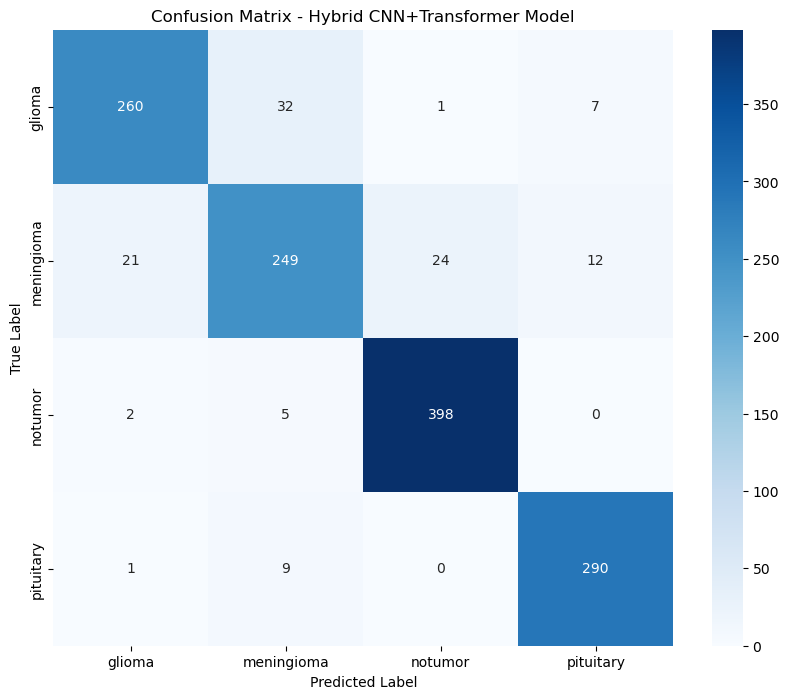


FINAL MODEL SUMMARY:
Architecture: Hybrid CNN+Transformer
Parameters: 1,552,724
Model Size: 5.92 MB
Test F1 Score: 0.9121
Test Accuracy: 0.9130


In [39]:
# Evaluate on test set
test_metrics = evaluate_model(model, test_loader, class_names, device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
model_size = total_params * 4 / (1024*1024)

print(f"\nFINAL MODEL SUMMARY:")
print(f"Architecture: Hybrid CNN+Transformer")
print(f"Parameters: {total_params:,}")
print(f"Model Size: {model_size:.2f} MB")
print(f"Test F1 Score: {test_metrics['f1_weighted']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")